# Where to open a new coffee shop?

In [1]:
!pip install rtree


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [150]:
denver = pd.read_csv('./data/denver.csv')
neighborhoods = gpd.read_file('./data/neighborhoods.shp')
census = pd.read_csv('./data/census.csv')

Starbucks locations in Denver, Colorado
- "StoreNumber" - Store Number as assigned by Starbucks
- "Name" - Name identifier for the store
- "PhoneNumber" - Phone number for the store
- "Street 1, 2, and 3" - Address for the store
- "PostalCode" - Zip code of the store
- "Longitude, Latitude" - Coordinates of the store

In [151]:
denver.head()

,StoreNumber,Name,PhoneNumber,Street1,Street2,Street3,PostalCode,Longitude,Latitude
0,27708-240564,Auraria Tivoli - Student Union,3035563700,900 Auraria Parkway,NaN,NaN,80204,-105.01,39.75
1,75828-94910,Grand Hyatt Denver,303-295-1234,1740 Welton St,NaN,NaN,802023940,-104.99,39.75
2,74105-23807,Safeway - Denver #1463,303-722-6117,2150 S Downing,NaN,NaN,802104528,-104.97,39.68
3,22871-102491,Safeway - Denver #1248,303-477-5091,2660 Federal Blvd,NaN,NaN,80211,-105.02,39.76
4,11105-100844,Highlands Garden Village,303-455-3382,4500 W 38th Ave,NaN,NaN,802122001,-105.05,39.77


Neighborhoods' geographical information
- "NBHD_ID" - Neighborhood ID (matches the census information)
- "NBHD_NAME" - Name of the statistical neighborhood
- "Geometry" - Polygon that defines the neighborhood

In [152]:
neighborhoods.head()

,NBHD_ID,NBHD_NAME,geometry
0,2,Auraria,"POLYGON ((-105.00042 39.74552, -105.00041 39.7..."
1,21,Cory - Merrill,"POLYGON ((-104.94070 39.69540, -104.94070 39.6..."
2,7,Belcaro,"POLYGON ((-104.94070 39.71156, -104.94069 39.7..."
3,70,Washington Park,"POLYGON ((-104.95931 39.71566, -104.95931 39.7..."
4,71,Washington Park West,"POLYGON ((-104.97342 39.68982, -104.97356 39.6..."


Demographic information
- "NBHD_ID" - Neighborhood ID (matches the geographical information)
- "NBHD_NAME' - Nieghborhood name
- "POPULATION_2010' - Population in 2010
- "AGE_ " - Number of people in each age bracket (< 18, 18-34, 35-65, and > 65)
- "NUM_HOUSEHOLDS" - Number of households in the neighborhood
- "FAMILIES" - Number of families in the neighborhood
- "NUM_HHLD_100K+" - Number of households with income above 100 thousand USD per year

In [153]:
census.head()

,NBHD_ID,NBHD_NAME,POPULATION_2010,AGE_LESS_18,AGE_18_TO_34,AGE_35_TO_65,AGE_65_PLUS,NUM_HOUSEHOLDS,FAMILIES,NUM_HHLD_100K+
0,1,Athmar Park,8898.0,2649.0,2406.0,3112.0,731.0,2781.0,1964.0,425.0
1,2,Auraria,705.0,7.0,635.0,57.0,6.0,60.0,15.0,NaN
2,3,Baker,4879.0,745.0,1762.0,2037.0,335.0,2447.0,833.0,NaN
3,4,Barnum,6111.0,2015.0,1647.0,2089.0,360.0,1782.0,1289.0,120.0
4,5,Barnum West,5376.0,1579.0,1380.0,1824.0,593.0,1704.0,1207.0,NaN


In [154]:
# Denver location dataset ----------------------------------------------
neighborhoods.crs = "EPSG:4326"
neighborhoods_3857 = neighborhoods.to_crs(epsg = 3857)
neighborhoods['area'] = neighborhoods_3857.geometry.area/10 ** 6

# Census missing data imputation
imp = IterativeImputer(max_iter=10, random_state=0)
census_imp = census.drop(columns = ['NBHD_ID', 'NBHD_NAME'])
census_imp = pd.DataFrame(imp.fit_transform(census_imp), columns = census_imp.columns)
census_imp.loc[census_imp['NUM_HHLD_100K+']<0, 'NUM_HHLD_100K+'] = 0
census_imp.loc[census_imp['NUM_HOUSEHOLDS'] <= census_imp['NUM_HHLD_100K+'], 'NUM_HHLD_100K+'] = 0
census_imp['NUM_HOUSEHOLDS'] <= census_imp['NUM_HHLD_100K+']

for col in census_imp.columns:
    census_imp[col] = census_imp[col].astype('int')
    
census_imputed = census[['NBHD_ID', 'NBHD_NAME']].join(census_imp)

In [155]:
neighborhoods.isna().sum()

NBHD_ID      0
NBHD_NAME    0
geometry     0
area         0
dtype: int64

---

In [156]:
# Data transformation ----------------------------------------------
census_neighbors = neighborhoods.merge(census_imputed, on='NBHD_NAME')
census_neighbors.drop(columns=['NBHD_ID_y'], inplace=True)
census_neighbors.rename(columns = {'NBHD_ID_x':'NBHD_ID'}, inplace=True)
census_neighbors['AGE_LESS_18_prop'] =census_neighbors['AGE_LESS_18'] / census_neighbors['POPULATION_2010']
census_neighbors['AGE_18_TO_34_prop'] =census_neighbors['AGE_18_TO_34'] / census_neighbors['POPULATION_2010']
census_neighbors['AGE_35_TO_65_prop'] =census_neighbors['AGE_35_TO_65'] / census_neighbors['POPULATION_2010']
census_neighbors['AGE_65_PLUS_prop'] =census_neighbors['AGE_65_PLUS'] / census_neighbors['POPULATION_2010']
census_neighbors['NUM_HHLD_100K+'].fillna(0,inplace=True)
census_neighbors['NUM_HHLD_100K_prop'] = census_neighbors['NUM_HHLD_100K+'] / census_neighbors['NUM_HOUSEHOLDS']
census_neighbors['density'] = census_neighbors['POPULATION_2010'] / census_neighbors['area'] 

census_neighbors['density_scaled'] = \
    (census_neighbors['density'] - census_neighbors['density'].min())/\
    (census_neighbors['density'].max() - census_neighbors['density'].min())

In [157]:
def plot_annotate(name, xy, xytext, color='black'):
    ax.annotate(text=name, xy=xy, xytext=xytext, size=16, arrowprops=dict(arrowstyle="->", color=color), 
                horizontalalignment='center', color=color)

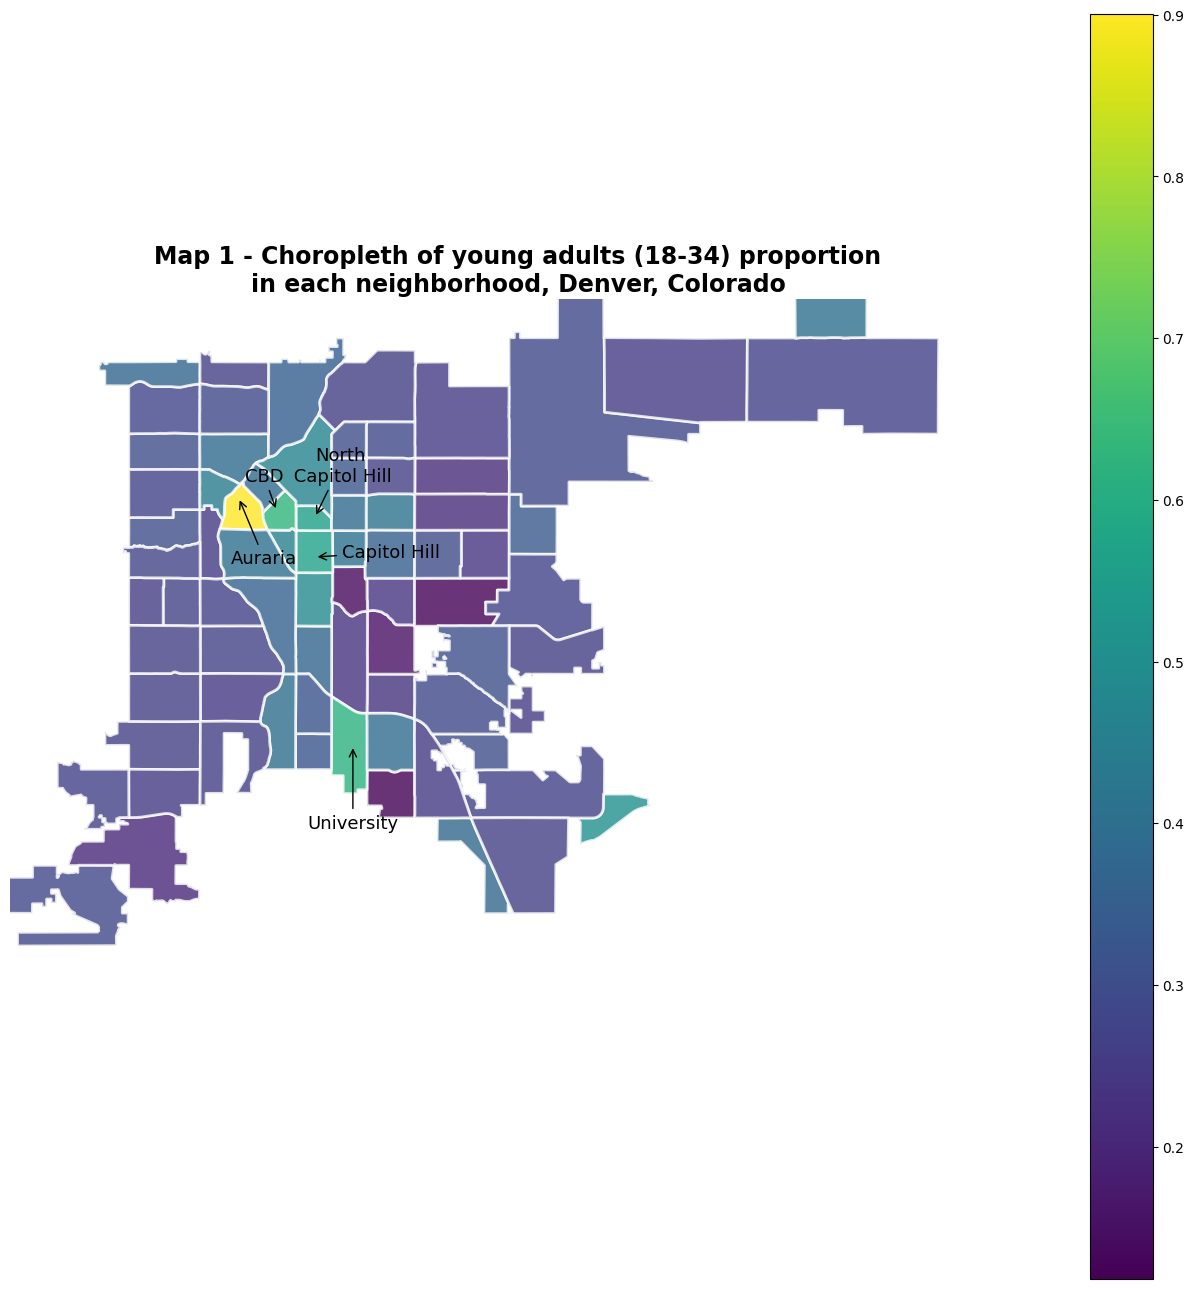

In [199]:
# First map
fig, ax= plt.subplots(1,1, figsize=(13, 13))

plt.title('Map 1 - Choropleth of young adults (18-34) proportion\nin each neighborhood, Denver, Colorado', size=17, weight='heavy')
census_neighbors.plot(column='AGE_18_TO_34_prop', cmap='viridis', legend=True,
                      edgecolor='white',linewidth=2, ax=ax, alpha=0.8)

    
plot_annotate('Auraria', (-105.01, 39.75), (-105, 39.73))
plot_annotate('University', (-104.965, 39.675), (-104.965, 39.65))
plot_annotate('CBD', (-104.995, 39.746), (-105, 39.755))
plot_annotate('Capitol Hill', (-104.98, 39.732), (-104.95, 39.732))
plot_annotate('North\n Capitol Hill', (-104.98, 39.744), (-104.97, 39.755))

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.xlim([-105.1,-104.7])
plt.ylim([39.6,39.81])
plt.axis('off')
plt.tight_layout()

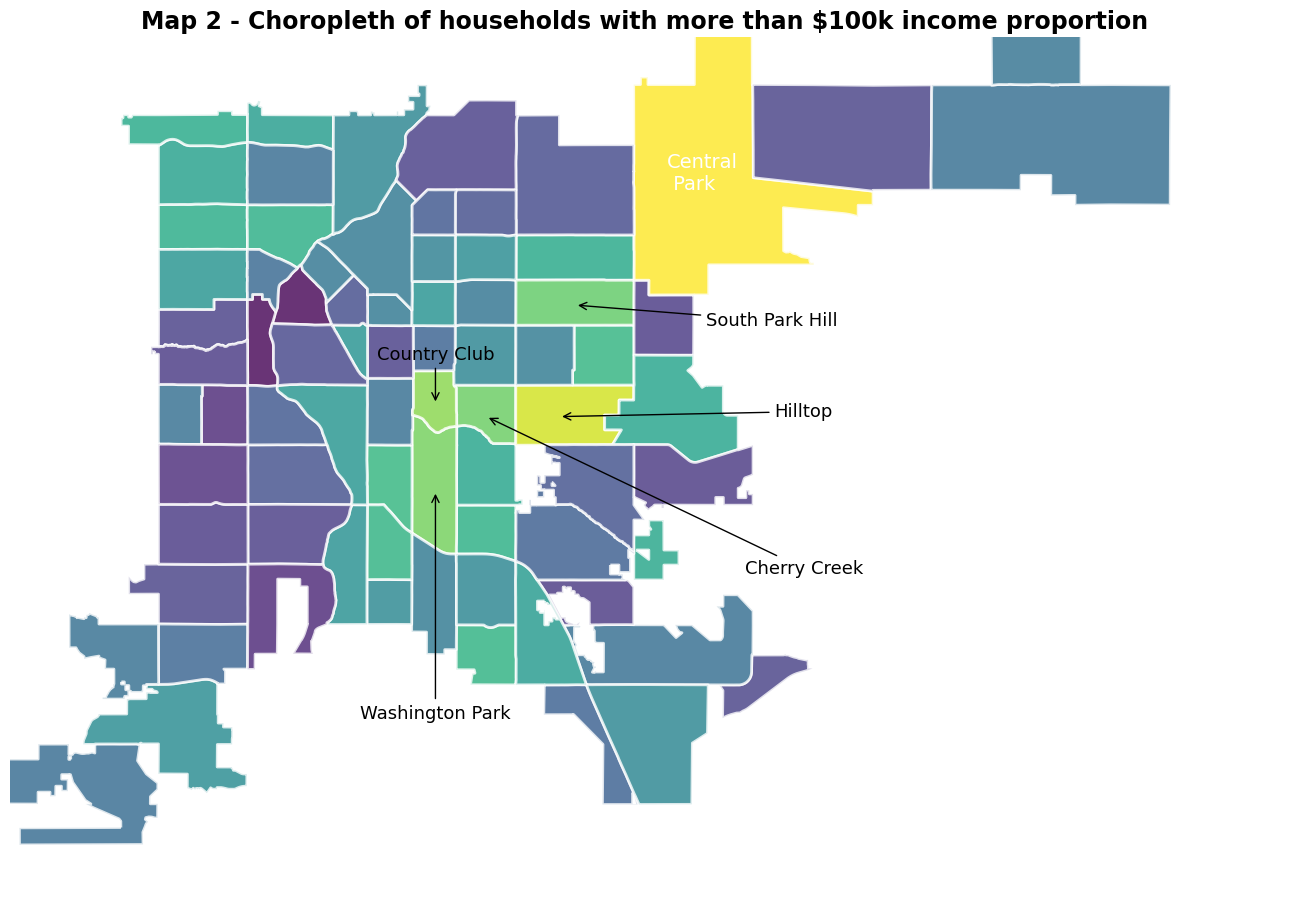

In [185]:
# Second map
fig, ax= plt.subplots(1,1, figsize=(13, 13))
plt.title('Map 2 - Choropleth of households with more than $100k income proportion', size=17, weight='heavy')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None) 
census_neighbors.plot(column='NUM_HHLD_100K_prop', cmap='viridis',
                      edgecolor='white',linewidth=2, ax=ax, alpha=0.8)


plot_annotate('Hilltop', (-104.927, 39.718), (-104.85, 39.718))
plot_annotate('Washington Park', (-104.966, 39.70), (-104.966, 39.645))
plot_annotate('Cherry Creek', (-104.95, 39.718), (-104.85, 39.68))
plot_annotate('Country Club', (-104.966, 39.721), (-104.966, 39.732))
plot_annotate('South Park Hill', (-104.922, 39.745), (-104.86, 39.74))

plt.text(s='Central\n Park', x=-104.893, y=39.773, size=14, color='white')

plt.xlim([-105.1,-104.7])
plt.ylim([39.6,39.81])

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.axis('off')
plt.tight_layout()

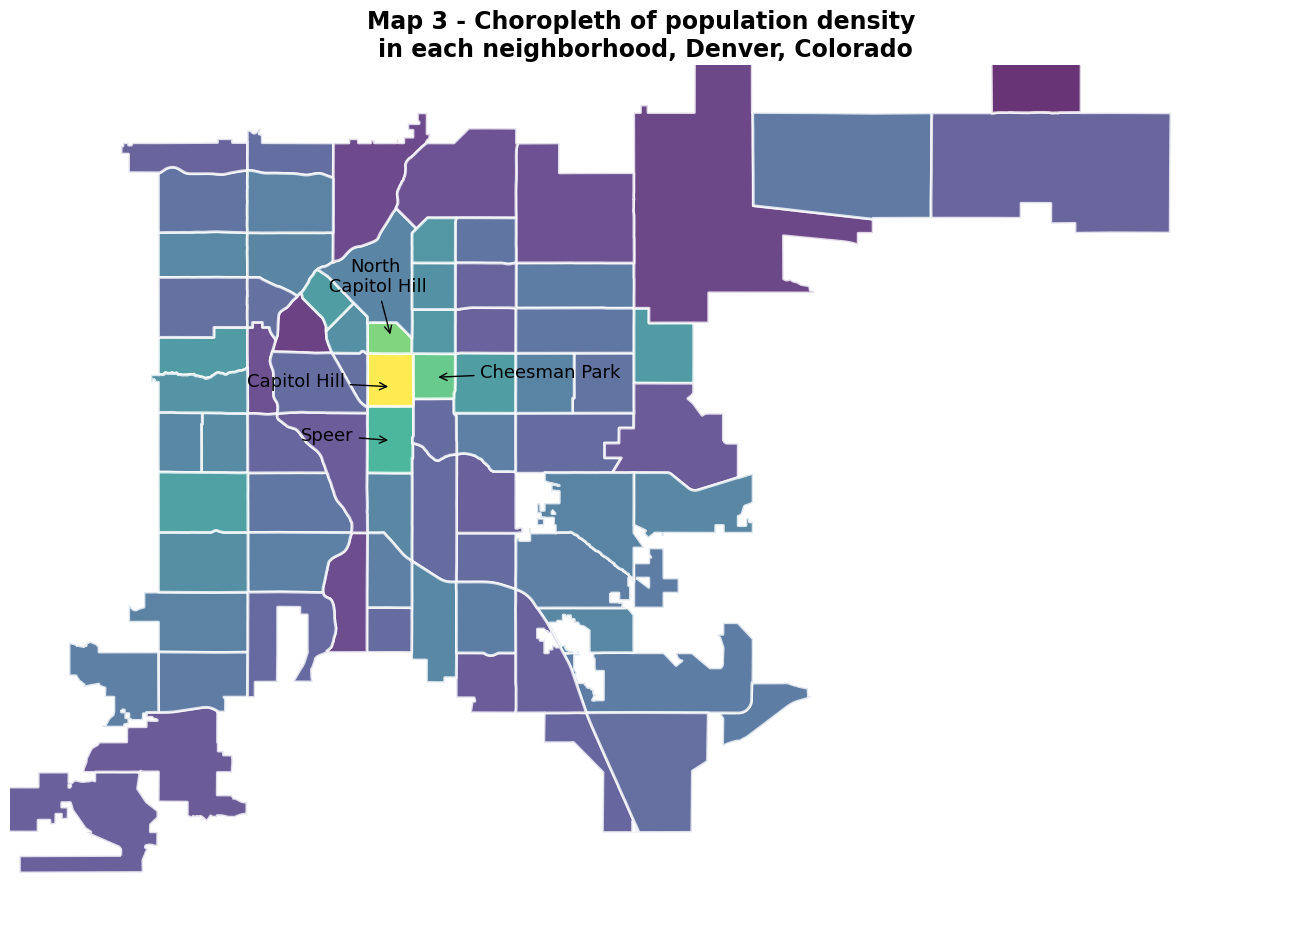

In [186]:
fig, ax= plt.subplots(1,1, figsize=(13, 13))

census_neighbors.plot(column='density', cmap='viridis', 
                      edgecolor='white',linewidth=2, ax=ax, alpha=0.8)
plt.title('Map 3 - Choropleth of population density \nin each neighborhood, Denver, Colorado', size=17, weight='heavy')
plot_annotate('Capitol Hill', (-104.98, 39.732), (-105.01, 39.732))
plot_annotate('North\n Capitol Hill', (-104.98, 39.744), (-104.985, 39.755))
plot_annotate('Cheesman Park', (-104.966, 39.7343), (-104.93, 39.7343))
plot_annotate('Speer', (-104.98, 39.719), (-105, 39.719))

plt.xlim([-105.1,-104.7])
plt.ylim([39.6,39.81])
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.axis('off')
plt.tight_layout()

In [181]:
denver_gpd = gpd.GeoDataFrame(
    denver, geometry=gpd.points_from_xy(denver['Longitude'], denver['Latitude']))

denver_gpd['geometry'] = denver_gpd.geometry.buffer(0.00001)
denver_gpd.crs = "EPSG:4326"
denver_4326 = denver_gpd.to_crs(4326)

denver_neighbors = neighborhoods.merge(denver_4326, how='left') 
denver_neighbors.dropna(subset=['Longitude'], inplace=True)

C:\Users\swell\AppData\Local\Temp\ipykernel_29860\1418185712.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  denver_gpd['geometry'] = denver_gpd.geometry.buffer(0.00001)


In [182]:
starbucks_density = denver_neighbors['NBHD_NAME'].value_counts().to_frame().reset_index()
starbucks_density.columns = ['NBHD_NAME', 'Count']
neighborhoods_density = neighborhoods.merge(starbucks_density, on='NBHD_NAME')

In [ ]:
fig, ax= plt.subplots(1,1, figsize=(13, 13))
plt.title('Map 4 - Choropleth of Starbucks branch locations \nin each neighborhood, Denver, Colorado',
          size=17, weight='heavy')

# Background map -------------------------------------------------
neighborhoods.plot(column ='NBHD_NAME', color='whitesmoke', edgecolor='gray', 
                       linestyle=':', ax=ax)
# Foreground map -------------------------------------------------
neighborhoods_density.plot(column='Count', cmap='viridis', edgecolor='black', linewidth=1.5, ax=ax,
                          alpha = 0.8)

# Annotations  -------------------------------------------------
def plot_annotate(name, xy, xytext):
    ax.annotate(text=name, xy=xy, xytext=xytext, size=13, arrowprops=dict(arrowstyle="->"), 
                horizontalalignment='center', color='black')
    
plot_annotate('CBD', (-104.993, 39.745), (-104.985, 39.76)) # 1
plot_annotate('Civic Center', (-104.987, 39.735), (-105.1, 39.7)) # 2
plot_annotate('Union Station', (-105, 39.75), (-105.02, 39.8)) # 3
plot_annotate('Central \nPark', (-104.885, 39.773), (-104.885, 39.771)) # 4
plot_annotate('Highland', (-105.01, 39.76), (-105.1, 39.76)) # 5
plot_annotate('University', (-104.965, 39.67), (-104.965, 39.65)) # 6
plot_annotate('Cherry Creek', (-104.95, 39.72), (-104.8, 39.72)) # 7 
plot_annotate('Cheesman Park', (-104.97, 39.73), (-104.94, 39.75)) # 8
plot_annotate('Lincoln Park', (-105, 39.735), (-105.1, 39.73)) # 9

# Axes ----------------------------------------------------
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
_ = plt.axis('off')

_ = plt.xlim([-105.15,-104.7])
_ = plt.ylim([39.6,39.835])

# plt.tight_layout()

In [ ]:
starbucks_branches = list(set(denver_neighbors.NBHD_NAME))
starbucks_neighbor = census_neighbors[census_neighbors.NBHD_NAME.isin(starbucks_branches )]\
    [['AGE_LESS_18_prop', 'AGE_18_TO_34_prop', 'AGE_35_TO_65_prop', 'AGE_65_PLUS_prop',
       'NUM_HHLD_100K_prop', 'density']]
no_starbucks_neighbor = census_neighbors[~census_neighbors.NBHD_NAME.isin(starbucks_branches )]\
    [['AGE_LESS_18_prop', 'AGE_18_TO_34_prop', 'AGE_35_TO_65_prop', 'AGE_65_PLUS_prop',
       'NUM_HHLD_100K_prop', 'density']]

stores_versus_non = starbucks_neighbor.mean().to_frame('Neighborhoods with starbucks store').\
join(no_starbucks_neighbor .mean().to_frame('Neighborhoods without starbucks store'))\
.rename(columns={'AGE_18_TO_34_prop':'18-34 proportion',
                'NUM_HHLD_100K_prop':'proportion of households'})
stores_versus_non.rename(index={'AGE_LESS_18_prop':'Less than 18 proportion',
                                'AGE_18_TO_34_prop':'18-34 proportion',
                                'AGE_35_TO_65_prop':'35-65 proportion',
                                'AGE_65_PLUS_prop':'greater than 65 proportion',                               
                                'NUM_HHLD_100K_prop':'proportion of income >100k',
                                'density':'Neighborhood Density'}, inplace=True)
stores_versus_non['Difference proportion'] = \
    abs(stores_versus_non['Neighborhoods with starbucks store']- stores_versus_non['Neighborhoods without starbucks store'])\
     /stores_versus_non['Neighborhoods without starbucks store'] 
stores_versus_non.style.background_gradient(subset=['Difference proportion'], cmap='coolwarm')

c:\Users\swell\OneDrive\Bureau\pythonista-data-science-ninja\venv\lib\site-packages\pandas\io\formats\style.py:3925: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\swell\OneDrive\Bureau\pythonista-data-science-ninja\venv\lib\site-packages\pandas\io\formats\style.py:3926: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Neighborhoods with starbucks store,Neighborhoods without starbucks store,Difference proportion
Less than 18 proportion,nan,0.200264,nan
18-34 proportion,nan,0.321701,nan
35-65 proportion,nan,0.373507,nan
greater than 65 proportion,nan,0.104528,nan
proportion of income >100k,nan,0.264167,nan
Neighborhood Density,nan,1424.278198,nan


In [ ]:
popular_neighborhoods = list(denver_neighbors['NBHD_NAME'].value_counts().head(9).index)
unpopular_neighborhoods = list(denver_neighbors['NBHD_NAME'].value_counts().tail(16).index)
pop_census = census_neighbors[census_neighbors.NBHD_NAME.isin(popular_neighborhoods)]\
    [['AGE_LESS_18_prop', 'AGE_18_TO_34_prop', 'AGE_35_TO_65_prop', 'AGE_65_PLUS_prop',
       'NUM_HHLD_100K_prop', 'density']]
not_pop_census = census_neighbors[~census_neighbors.NBHD_NAME.isin(popular_neighborhoods)]\
    [['AGE_LESS_18_prop', 'AGE_18_TO_34_prop', 'AGE_35_TO_65_prop', 'AGE_65_PLUS_prop',
       'NUM_HHLD_100K_prop', 'density']]

pop_versus_nonpop = pop_census.mean().to_frame('Neighborhoods with 3 and more branches').\
join(not_pop_census.mean().to_frame('Neighboorhood with only 1 store location'))\
.rename(columns={'AGE_18_TO_34_prop':'18-34 proportion',
                'NUM_HHLD_100K_prop':'proportion of households'})
pop_versus_nonpop.rename(index={'AGE_LESS_18_prop':'Less than 18 proportion',
                                'AGE_18_TO_34_prop':'18-34 proportion',
                                'AGE_35_TO_65_prop':'35-65 proportion',
                                'AGE_65_PLUS_prop':'greater than 65 proportion',                               
                                'NUM_HHLD_100K_prop':'proportion of income >100k',
                                'density':'Neighborhood Density'}, inplace=True)
pop_versus_nonpop['Difference proportion'] = \
    abs(pop_versus_nonpop['Neighborhoods with 3 and more branches']- pop_versus_nonpop['Neighboorhood with only 1 store location'])\
     /pop_versus_nonpop['Neighboorhood with only 1 store location'] 
pop_versus_nonpop.style.background_gradient(subset=['Difference proportion'], cmap='coolwarm')

c:\Users\swell\OneDrive\Bureau\pythonista-data-science-ninja\venv\lib\site-packages\pandas\io\formats\style.py:3925: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\swell\OneDrive\Bureau\pythonista-data-science-ninja\venv\lib\site-packages\pandas\io\formats\style.py:3926: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Neighborhoods with 3 and more branches,Neighboorhood with only 1 store location,Difference proportion
Less than 18 proportion,nan,0.200264,nan
18-34 proportion,nan,0.321701,nan
35-65 proportion,nan,0.373507,nan
greater than 65 proportion,nan,0.104528,nan
proportion of income >100k,nan,0.264167,nan
Neighborhood Density,nan,1424.278198,nan


In [ ]:
# 25% and median
top_neighbors = census_neighbors[(census_neighbors['AGE_LESS_18_prop'] < 0.19) & 
                (census_neighbors['NUM_HHLD_100K_prop'] >= 0.15) & 
                (census_neighbors['density_scaled'] >= 0.19) &
                ((census_neighbors['AGE_18_TO_34_prop'] >= 0.28) | 
                (census_neighbors['NUM_HHLD_100K_prop'] >= 0.25) | 
                (census_neighbors['density_scaled'] >= 0.28))]\
                [['NBHD_NAME', 'AGE_LESS_18_prop','AGE_18_TO_34_prop', 'NUM_HHLD_100K_prop', 'density_scaled']]\
    .sort_values(by='AGE_18_TO_34_prop', ascending=False)

#top_neighbors['average'] = top_neighbors.mean(axis=1)
top_neighbors['average'] = ((1 - top_neighbors['AGE_LESS_18_prop']) +
                           2 * top_neighbors['AGE_18_TO_34_prop'] +
                           2 * top_neighbors['NUM_HHLD_100K_prop'] +
                           top_neighbors['density_scaled']) / 8
top_neighbors['rank'] = top_neighbors['average'].rank(ascending=False).astype('int')
top_neighbors.drop(columns=['average'], inplace=True)
top_quartile = top_neighbors.sort_values(by='rank', ascending=True)

denver_gpd = gpd.GeoDataFrame(
    denver, geometry=gpd.points_from_xy(denver['Longitude'], denver['Latitude']))

denver_gpd['geometry'] = denver_gpd.geometry.buffer(0.00001)
denver_gpd.crs = "EPSG:4326"
denver_4326 = denver_gpd.to_crs(epsg = 4326)

denver_neighbors = neighborhoods.sjoin(denver_4326, how='left') 
denver_neighbors.dropna(subset=['Longitude'], inplace=True)

starbucks_neighborhood_count = \
    denver_neighbors['NBHD_NAME'].value_counts().to_frame('Starbuck Branches')

starbucks_neighborhood_table = starbucks_neighborhood_count.reset_index()
starbucks_neighborhood_table.rename(columns={'index':'NBHD_NAME'}, inplace=True)
top = top_quartile.merge(starbucks_neighborhood_table, how='left', on='NBHD_NAME').fillna(0)

top.rename(columns= {'NBHD_NAME':'Neighborhood Name',
                             'AGE_LESS_18_prop':'Less than 18 Proportion',
                             'AGE_18_TO_34_prop':'18-35 Proportion',
                             'NUM_HHLD_100K_prop':'Proportion of income >100k',
                             'density_scaled':'Scaled Density',
                             'rank':'Rank'}, inplace=True)
top['Starbuck Branches'] = top['Starbuck Branches'].astype('int')

top10 = top[['Neighborhood Name', 'Rank', 'Less than 18 Proportion', '18-35 Proportion', 
    'Proportion of income >100k', 'Scaled Density', 'Starbuck Branches']].copy().head(10)

top10.style.background_gradient(subset=['Less than 18 Proportion','18-35 Proportion',
                                               'Proportion of income >100k', 'Scaled Density'], cmap='coolwarm_r')

C:\Users\swell\AppData\Local\Temp\ipykernel_29860\2490122078.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  denver_gpd['geometry'] = denver_gpd.geometry.buffer(0.00001)
c:\Users\swell\OneDrive\Bureau\pythonista-data-science-ninja\venv\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


,Neighborhood Name,Rank,Less than 18 Proportion,18-35 Proportion,Proportion of income >100k,Scaled Density,Starbuck Branches
0,North Capitol Hill,1,0.033316,0.556071,0.262270,0.759047,0
1,University,2,0.088107,0.616960,0.263634,0.345688,3
2,Speer,3,0.064543,0.489410,0.230285,0.589631,0
3,Cheesman Park,4,0.063982,0.409986,0.197455,0.695637,3
4,Washington Park West,5,0.126232,0.369936,0.432987,0.336387,0
5,Civic Center,6,0.027901,0.454661,0.333333,0.237680,5
6,Highland,7,0.153755,0.387828,0.412491,0.335124,3
7,City Park West,8,0.093518,0.389967,0.335664,0.415544,0
8,Cherry Creek,9,0.073895,0.235105,0.513269,0.306423,3
9,Union Station,10,0.026449,0.387994,0.253746,0.454849,5


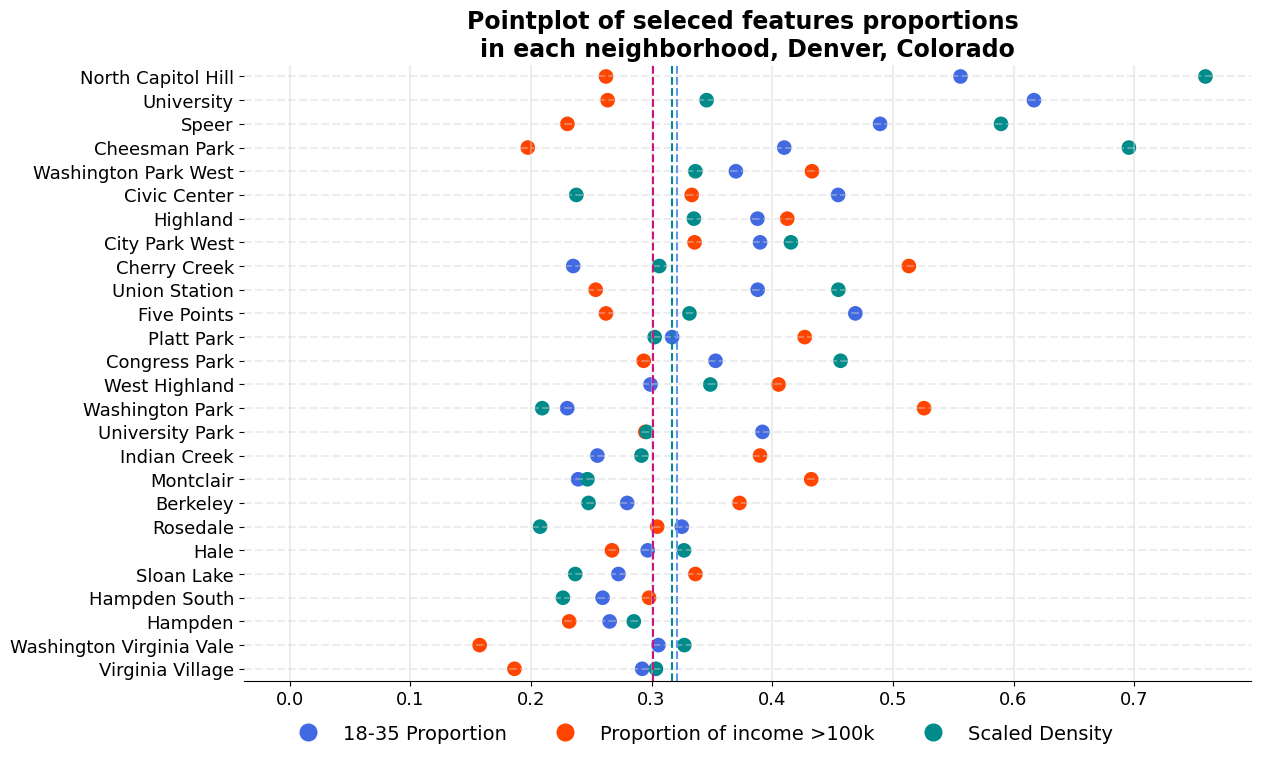

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(13, 8))
plt.title('Pointplot of seleced features proportions \nin each neighborhood, Denver, Colorado',
          size=17, weight='heavy')

# main plots ----------------------------------------------

sns.pointplot(data=top, x='18-35 Proportion', y='Neighborhood Name', 
              color = 'RoyalBlue', join=False, ax=ax, markers='o', scale=1.2)

sns.pointplot(data=top, x='Proportion of income >100k', y='Neighborhood Name', 
              color = 'OrangeRed', join=False, ax=ax, markers='o', scale=1.2)

sns.pointplot(data=top, x='Scaled Density', y='Neighborhood Name', 
              color = 'DarkCyan', join=False, ax=ax, scale=1.2)

# vlines and hlines ----------------------------------------------

for i in range(len(top_neighbors)):
    plt.axhline(y=i, linestyle='--', alpha=0.4, color='lightgray')
    
for i in np.linspace(0, 0.7, 8):
    plt.axvline(x=i, linestyle='-', alpha=0.4, color='lightgray')
    
plt.axvline(top['18-35 Proportion'].median(),  color = 'CornflowerBlue', linestyle='--')
plt.axvline(top['Proportion of income >100k'].median(),  color = 'MediumVioletRed', linestyle='--')
plt.axvline(top['Scaled Density'].median(),  color = 'DarkCyan', linestyle='--')

handles = [plt.Line2D([], [], color='RoyalBlue', marker='o', linewidth=0, markersize=12),
           plt.Line2D([], [], color='OrangeRed', marker='o', linewidth=0, markersize=12),
           plt.Line2D([], [], color='DarkCyan', marker='o', linewidth=0, markersize=12)]

# ticks and legends ----------------------------------------------

ax.legend(handles=handles, labels=['18-35 Proportion','Proportion of income >100k','Scaled Density'],
         loc='lower right', ncol=3, fontsize=14,
         bbox_to_anchor=(0.88, -0.13), frameon=False)

ax.tick_params(axis='both', which='major', labelsize=13)

plt.xlabel('')  
plt.ylabel('')
sns.despine(left=True)